# Logistic Regression

In this notebook we're going to build a **classification model**
on the credit default dataset.

Let's import the packages and load the dataset into a pandas dataframe


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

df = pd.read_csv('./data/credit_default_sampled.csv')

df.shape


(833, 4)

## The dataset
The dataset has 833 samples of people who did or did not default on their credit.


In [3]:
df.head()

,default,student,balance,income
0,1,Yes,1.486998,17.854397
1,1,Yes,2.205800,14.271492
2,1,Yes,1.774694,20.359506
3,1,No,1.889599,48.956172
4,1,Yes,1.899391,20.655200


The outcome variable is binary with 500 people not defaulting and 333 defaulting


In [4]:
df.default.value_counts()

0    500
1    333
Name: default, dtype: int64

The predictors are the income and balance variables

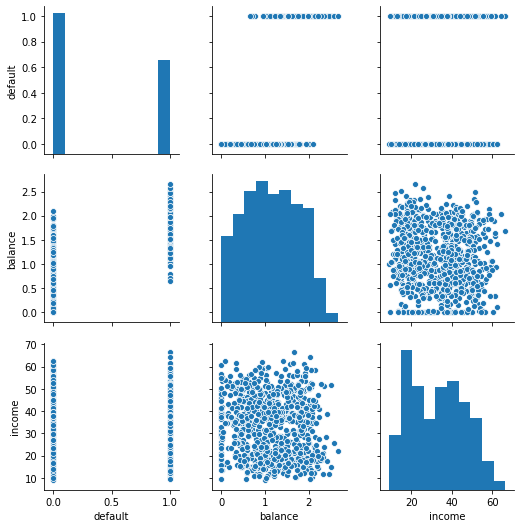

In [6]:
sns.pairplot(df)

## Logistic regression

The dataset also includes a categorical variable indicating whether the person is a student or not
We're not taking this variable into account.

Let's build a simple classification model
using the ```logit``` function of the ```statsmodels``` library


In [7]:
result = smf.logit( 'default ~ income + balance', data = df ).fit()
result.summary()



Optimization terminated successfully.
         Current function value: 0.248126
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                  833
Model:                          Logit   Df Residuals:                      830
Method:                           MLE   Df Model:                            2
Date:                Thu, 18 Jul 2019   Pseudo R-squ.:                  0.6313
Time:                        16:16:56   Log-Likelihood:                -206.69
converged:                       True   LL-Null:                       -560.54
                                        LLR p-value:                2.116e-154
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.1161      0.736    -12.386      0.000     -10.559      -7.674
income         0.0210      0.010      2.135      0.033       0.002       0.040
balance        6.2112      0.443     14.023      0.000       5.343       7.079
==============================================================================
"""

We get a Pseudo R-squared of 0.63

In [8]:
result.prsquared

0.6312663628456725

The LLR p-value is way below 0.05
which tells us that our model is better than a simple constant model

In [9]:
result.llr_pvalue


2.1161941826539855e-154

And the p-values of the coefficients are also below the 0.05 threshold.

Note that the p-value for the income coefficient
equals 0.03 raising some doubts about its reliability

However the associated confidence interval
does not contain the 0 value.
So we'll keep the income variable as predictor.


In [10]:
result.conf_int()

,0,1
Intercept,-10.558632,-7.673522
income,0.001718,0.040198
balance,5.343111,7.079329


Our goal is to see how the model classified each sample.
That will allow us to calculate its accuracy.


## Predicted class

The predicted class is not directly available from the result object.

We're going to calculate the predicted class for each sample from the fitted values.


Let's look at the histogram of the fittedvalues


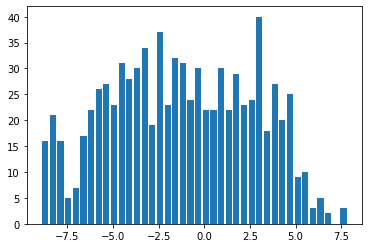

In [11]:
plt.hist(result.fittedvalues, bins = 40, rwidth=0.8);

We see that the fitted values are not contained within the 0 - 1 range

The fitted values therefore are not the probabilities of a sample belonging to one class or the other.

To obtain that probability we need to apply the logistic function to the fitted values

Let's define the logistic function


In [12]:
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))


And apply it to the fitted values. Let's call the output yhat. 

yhat is contained between 0 and 1 and therefore it can be interpreted as a probability


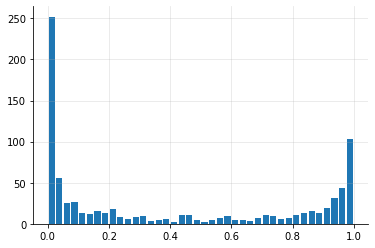

In [16]:
yhat = logistic(result.fittedvalues)

plt.hist(yhat, bins = 40, rwidth=0.8);
plt.grid(alpha =0.3)
sns.despine()

We see that our model is pretty good at deciding if a sample has a low
or high probability of defaulting
since we have two peaks near 0  and 1.

This does not mean that our model is correct in its classification
but at least it is not hesitating.

## Predict function
There's a more direct way to obtain the classification probabilities
by applying the ```predict``` function directly to the samples


In [17]:
yhat = result.predict(df[['income', 'balance']])

We still need to know which class each samples has been assigned to

Let's build the following simple rule:

* If the probability is below 0.5,

* the sample belongs to the 0 class (non default)

* otherwise it belongs to the 1 class (default)

We get the predicted classes with the boolean

```yhat greater than 0.5```

and casting it as an integer.


In [18]:
predicted_class = (yhat > 0.5).astype(int)

And predicted_class is now a list of 0 and 1s

In [19]:
predicted_class[:10]

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
dtype: int64

## Confusion matrix

No we want to know several things


* how many samples were correctly classified for each class
* how many samples were *not* correctly classified for each class

These 4 numbers are given by the confusion matrix




In [22]:
result.pred_table()


array([[460.,  40.],
       [ 47., 286.]])

This table reads as

* 460 and 286 samples were correctly classified as non default and default
* 40 non default samples were incorrectly classified as default
* 47 default samples were incorrectly classified as non default


From that table we can calculate the **accuracy** which is defined as the number of correctly classified samples
over the total number of samples

Here the accuracy equals

    


In [24]:
accuracy = (460 + 286 ) / 833
print("Accuracy {:.4f}".format(accuracy))



Accuracy 0.8956


which gives us an accuracy of 89.56%

Not bad a result.